In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Shlok/Prepared_Datasets

# Dataset Preparation

In [ ]:
import pandas as pd
import numpy as np

#Find the relevant data files
#"Demographic Variables and Sample Weights" for demographics
#"Diabetes" for diabetes questionnaire data
#"Vitamin D" for vitamin D levels in laboratory data
#"Body Measures" in examination data
# Read XPT files
demographics = pd.read_sas('DEMO_E.XPT') #DEMO_F.XPT DEMO_G.XPT DEMO_H.XPT DEMO_I.XPT DEMO_J.XPT
diabetes = pd.read_sas('DIQ_E.XPT') #DIQ_F.XPT DIQ_G.XPT DIQ_H.XPT DIQ_I.XPT DIQ_J.XPT
vitamin_d = pd.read_sas('VID_E.XPT') #
body_measures = pd.read_sas('BMX_E.XPT')
bloodpressure_measures = pd.read_sas('BPX_E.XPT')


In [ ]:
# Merge datasets on the unique identifier (SEQN)
merged_data = demographics.merge(diabetes, on='SEQN') \
                          .merge(vitamin_d, on='SEQN') \
                          .merge(bloodpressure_measures, on='SEQN')\
                          .merge(body_measures, on='SEQN')

# Select relevant variables
relevant_vars = ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'BMXBMI',
                 'DIQ010', 'LBXVE3MS', 'LBXVIDMS', 'BPXSY1', 'BPXDI1']

new_dataset = merged_data[relevant_vars].copy()

# Rename columns for clarity
new_dataset.columns = ['ID', 'Gender', 'Age', 'Race', 'BMI',
                       'Diabetes_Diagnosis', 'HbA1c', 'Vitamin_D',
                       'Systolic_BP', 'Diastolic_BP']

# Filter for diabetic patients (self-reported diagnosis or HbA1c >= 6.5%)
new_dataset = new_dataset[(new_dataset['Diabetes_Diagnosis'] == 1) |
                          (new_dataset['HbA1c'] >= 6.5)]

# Create binary classification for vitamin D deficiency (< 20 ng/mL)
new_dataset['Vitamin_D_Deficient'] = (new_dataset['Vitamin_D'] < 20).astype(int)

# Handle missing values (you may want to use more sophisticated imputation methods)
new_dataset = new_dataset.dropna()

# Save the new dataset
new_dataset.to_csv('diabetic_vitamin_d_dataset_2007-08.csv', index=False)

print(new_dataset.head())
print(f"Dataset shape: {new_dataset.shape}")

# Print the number of classes in Vitamin_D_Deficient column
vitamin_d_classes = new_dataset['Vitamin_D_Deficient'].value_counts()
print("\nNumber of classes in Vitamin_D_Deficient column:")
print(vitamin_d_classes)
print(f"\nTotal number of classes: {len(vitamin_d_classes)}")

#Combine Prepared Datasets for better Class representation of Vitamin D deficiency.

#All the datasets contain imbalanced Vitamin D Deficiency Class, which we try to handle using techniques like SMOTE using code.

In [ ]:
import pandas as pd
import glob

# List of all dataset filenames
datasets = [
    'diabetic_vitamin_d_dataset_2007-08.csv',
    'diabetic_vitamin_d_dataset_2009-10.csv',
    'diabetic_vitamin_d_dataset_2011-12.csv',
    'diabetic_vitamin_d_dataset_2013-14.csv',
    'diabetic_vitamin_d_dataset_2015-16.csv',
    'diabetic_vitamin_d_dataset_2017-18.csv'
]

# Read the main dataset (2007-08)
main_df = pd.read_csv('diabetic_vitamin_d_dataset_2007-08.csv')

# Initialize an empty list to store data from other datasets
all_data = []

# Process each dataset
for dataset in datasets[1:]:  # Skip the first dataset as it's already loaded
    df = pd.read_csv(dataset)

    # Filter rows where Vitamin_D_Deficient == 1
    deficient = df[df['Vitamin_D_Deficient'] == 1]

    # Append to the list
    all_data.append(deficient)

# Concatenate all data
all_additional = pd.concat(all_data, ignore_index=True)

# Combine main_df with all_additional
combined_df = pd.concat([main_df, all_additional], ignore_index=True)

# Remove duplicate rows based on 'ID', keeping the first occurrence
combined_df = combined_df.drop_duplicates(subset='ID', keep='first')

# Sort the combined dataset by 'ID' in ascending order
combined_df = combined_df.sort_values('ID')

# Reset the index
combined_df = combined_df.reset_index(drop=True)

# Save the combined dataset
combined_df.to_csv('modified_vitamin_d_dataset.csv', index=False)

print("Combined dataset saved as 'modified_vitamin_d_dataset.csv'")
print(f"Total number of rows in the combined dataset: {len(combined_df)}")

print(combined_df.head())
print(f"Dataset shape: {combined_df.shape}")

# Print the number of classes in Vitamin_D_Deficient column
vitamin_d_classes = combined_df['Vitamin_D_Deficient'].value_counts()
print("\nNumber of classes in Vitamin_D_Deficient column:")
print(vitamin_d_classes)
print(f"\nTotal number of classes: {len(vitamin_d_classes)}")


Combined dataset has been created and saved as 'modified_vitamin_d_dataset.csv'
Total number of rows in the combined dataset: 995
        ID  Gender   Age  Race    BMI  Diabetes_Diagnosis  HbA1c  Vitamin_D  \
0  41477.0     1.0  71.0   3.0  30.05                 1.0   2.42       81.8   
1  41483.0     1.0  66.0   4.0  44.06                 1.0   1.16       53.3   
2  41491.0     2.0  11.0   3.0  15.69                 2.0  10.10       70.2   
3  41495.0     1.0  61.0   3.0  25.53                 3.0   6.93       76.5   
4  41496.0     2.0  64.0   1.0  28.37                 1.0   2.11       98.0   

   Systolic_BP  Diastolic_BP  Vitamin_D_Deficient  
0        144.0          60.0                    0  
1        110.0          62.0                    0  
2        120.0          76.0                    0  
3        102.0          64.0                    0  
4        192.0          86.0                    0  
Dataset shape: (995, 11)

Number of classes in Vitamin_D_Deficient column:
Vitamin_

In [ ]:
!pip install SHAP imblearn

#Predictive modeling approach using XGBoost on the vitamin D deficiency dataset

## Code Breakdown Summary

### 1. Data Preparation
- **Loading Data**: Imports the dataset and creates a binary target variable for vitamin D deficiency.
- **Feature Selection**: Drops irrelevant columns and converts categorical variables into dummy variables.
- **Feature Engineering**: Creates new features using interaction terms and categorical bins for HbA1c, BMI, and Age.

### 2. Data Splitting
- Splits the dataset into training and testing sets using stratified sampling to maintain target distribution.

### 3. Model Pipeline
- Constructs a pipeline that includes scaling, SMOTE for class imbalance, and the XGBoost classifier.

### 4. Hyperparameter Tuning
- Utilizes `GridSearchCV` to optimize hyperparameters of the XGBoost model based on the F1 score.

### 5. Model Evaluation
- Evaluates model performance using metrics such as ROC AUC, Cohen's Kappa, and F1 score.

### 6. SHAP Analysis
- Performs SHAP value analysis to interpret feature contributions to the model's predictions.

### 7. Optimal Threshold Calculation
- Calculates the optimal classification threshold based on F1 scores to enhance precision and recall.

### 8. Feature Importance
- Extracts and displays the top 10 important features, aiding in understanding the model's decision-making process.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, cohen_kappa_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import shap

# Load the data
data = pd.read_csv('modified_vitamin_d_dataset.csv')

# Redefine the target variable
data['Vitamin_D_Deficient'] = (data['Vitamin_D'] < 20).astype(int)


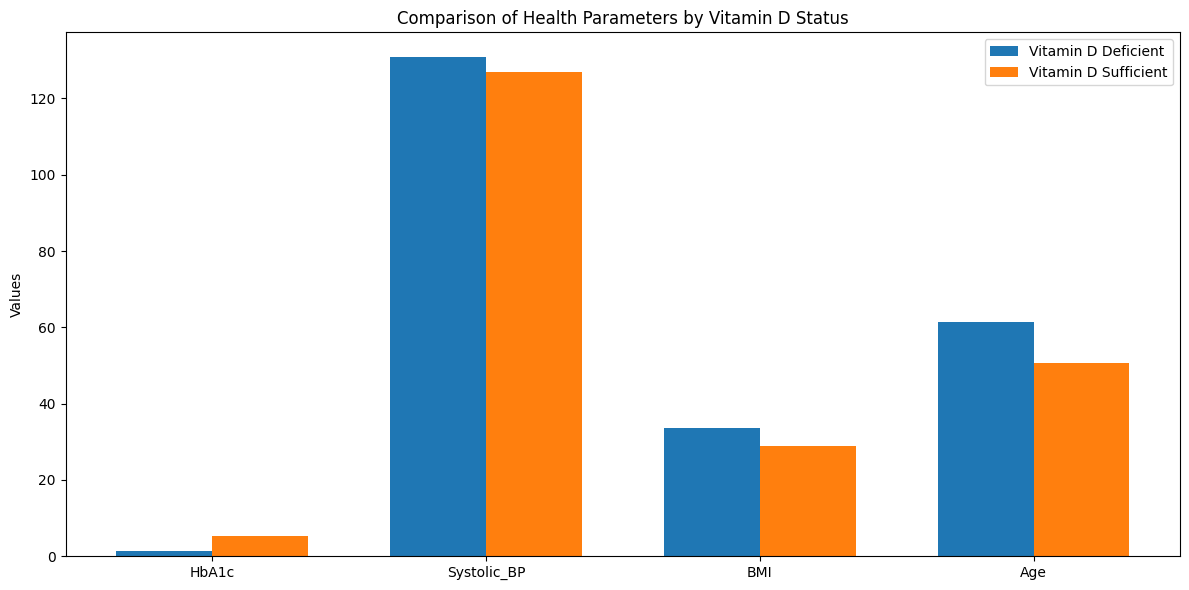

In [ ]:
#Comparison of Health Parameters by Vitamin D Status
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'data' is your DataFrame
vit_d_def = data[data['Vitamin_D_Deficient'] == 1]
vit_d_suf = data[data['Vitamin_D_Deficient'] == 0]

parameters = ['HbA1c', 'Systolic_BP', 'BMI', 'Age']
def_means = [vit_d_def[param].mean() for param in parameters]
suf_means = [vit_d_suf[param].mean() for param in parameters]

x = np.arange(len(parameters))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, def_means, width, label='Vitamin D Deficient')
rects2 = ax.bar(x + width/2, suf_means, width, label='Vitamin D Sufficient')

ax.set_ylabel('Values')
ax.set_title('Comparison of Health Parameters by Vitamin D Status')
ax.set_xticks(x)
ax.set_xticklabels(parameters)
ax.legend()

plt.tight_layout()
plt.show()

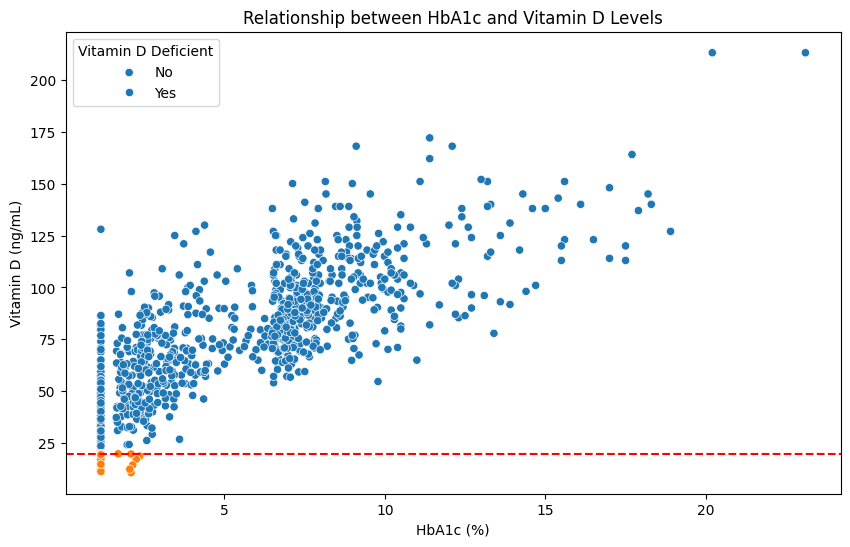

In [ ]:
#Relationship between diabetes severity (as indicated by HbA1c levels) and vitamin D levels

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='HbA1c', y='Vitamin_D', hue='Vitamin_D_Deficient')
plt.title('Relationship between HbA1c and Vitamin D Levels')
plt.xlabel('HbA1c (%)')
plt.ylabel('Vitamin D (ng/mL)')
plt.axhline(y=20, color='r', linestyle='--')  # Line indicating vitamin D deficiency threshold
plt.legend(title='Vitamin D Deficient', labels=['No', 'Yes'])
plt.show()

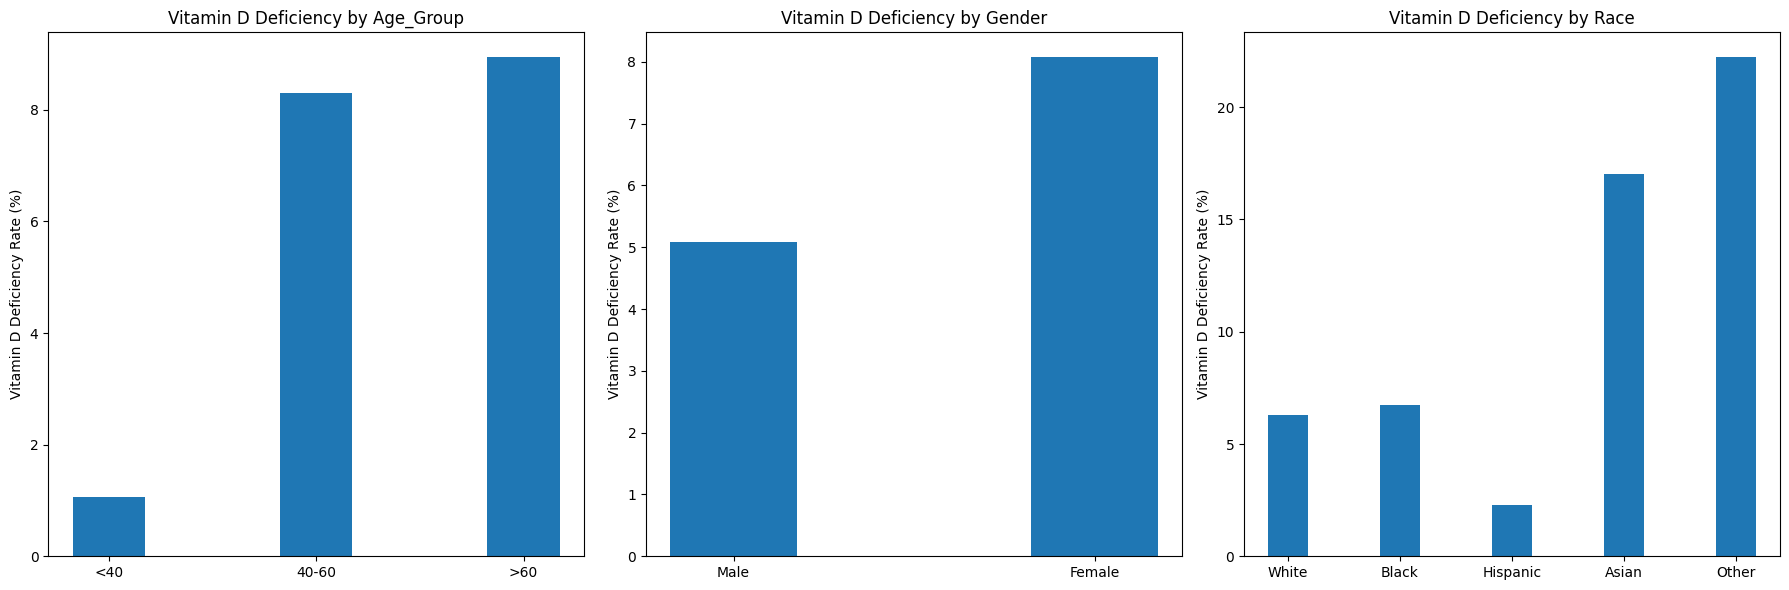

In [ ]:
#Vitamin D Deficiency by demographics
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'data' is your DataFrame
demographics = ['Age_Group', 'Gender', 'Race']
age_groups = ['<40', '40-60', '>60']
genders = ['Male', 'Female']
races = ['White', 'Black', 'Hispanic', 'Asian', 'Other']

def vit_d_def_rate(group):
    return (group['Vitamin_D_Deficient'] == 1).mean() * 100

data['Age_Group'] = pd.cut(data['Age'], bins=[0, 40, 60, 100], labels=age_groups)

rates = []
for demo in demographics:
    if demo == 'Age_Group':
        rates.append([vit_d_def_rate(data[data['Age_Group'] == group]) for group in age_groups])
    elif demo == 'Gender':
        rates.append([vit_d_def_rate(data[data['Gender'] == 1]), vit_d_def_rate(data[data['Gender'] == 2])])
    else:  # Race
        rates.append([vit_d_def_rate(data[data['Race'] == race]) for race in range(1, 6)])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
width = 0.35

for i, (demo, rate) in enumerate(zip(demographics, rates)):
    x = np.arange(len(rate))
    axes[i].bar(x, rate, width)
    axes[i].set_ylabel('Vitamin D Deficiency Rate (%)')
    axes[i].set_title(f'Vitamin D Deficiency by {demo}')
    if demo == 'Age_Group':
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(age_groups)
    elif demo == 'Gender':
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(genders)
    else:  # Race
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(races)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, cohen_kappa_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import shap

# Load the data
data = pd.read_csv('modified_vitamin_d_dataset.csv')

# Redefine the target variable
data['Vitamin_D_Deficient'] = (data['Vitamin_D'] < 20).astype(int)


In [ ]:
# Separate features and target
X = data.drop(['ID', 'Vitamin_D_Deficient', 'Vitamin_D'], axis=1)
y = data['Vitamin_D_Deficient']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, columns=['Gender', 'Race', 'Diabetes_Diagnosis'])

# Feature engineering
X['HbA1c_Category'] = pd.cut(X['HbA1c'], bins=[0, 5.7, 6.4, 7, 8, np.inf], labels=['Normal', 'Prediabetes', 'Mild', 'Moderate', 'Severe'])
X = pd.get_dummies(X, columns=['HbA1c_Category'])
X['BMI_Category'] = pd.cut(X['BMI'], bins=[0, 18.5, 25, 30, 35, np.inf], labels=['Underweight', 'Normal', 'Overweight', 'Obese', 'Severely Obese'])
X = pd.get_dummies(X, columns=['BMI_Category'])
X['Age_Category'] = pd.cut(X['Age'], bins=[0, 18, 30, 50, 65, np.inf], labels=['Under 18', '18-30', '31-50', '51-65', 'Over 65'])
X = pd.get_dummies(X, columns=['Age_Category'])

# Interaction terms
X['HbA1c_BMI'] = X['HbA1c'] * X['BMI']
X['HbA1c_Age'] = X['HbA1c'] * X['Age']
X['BMI_Age'] = X['BMI'] * X['Age']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create a pipeline with SMOTE and XGBoost
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42))
])

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.3]
}

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print additional metrics
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Cohen's Kappa Score: {cohen_kappa_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

# SHAP value analysis
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Shlok/Prepared_Datasets/results1/shap_summary_xgboost.png')
plt.close()

# Find optimal threshold
thresholds = np.arange(0, 1, 0.01)
f1_scores = [f1_score(y_test, y_pred_proba > threshold) for threshold in thresholds]
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal threshold: {optimal_threshold:.2f}")

# Make predictions with optimal threshold
y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)

# Print the classification report with optimal threshold
print("\nClassification Report (Optimal Threshold):")
print(classification_report(y_test, y_pred_optimal))

# Print feature importances
feature_importance = best_model.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(10)
print("\nTop 10 Important Features:")
print(feature_importance_df)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       186
           1       0.25      0.69      0.37        13

    accuracy                           0.84       199
   macro avg       0.61      0.77      0.64       199
weighted avg       0.93      0.84      0.88       199

ROC AUC Score: 0.8364
Cohen's Kappa Score: 0.3002
F1 Score: 0.3673
Optimal threshold: 0.43

Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

           0       0.99      0.83      0.90       186
           1       0.26      0.85      0.39        13

    accuracy                           0.83       199
   macro avg       0.62      0.84      0.65       199
weighted avg       0.94      0.83      0.87       199


Top 10 Important Features:
               feature  importance
2                HbA1c    0.442306
23  BMI_Category_Obese    0.041487
10            Race_4.0    0.040213
5           Gender_1

## XGBoost and XGBoost Weighted Models


### 1. Data Preparation
- **Loading Data**: The dataset is loaded, and a binary target variable (`Vitamin_D_Deficient`) is created based on vitamin D levels.
- **Feature Selection**: Unnecessary columns are dropped, and categorical variables are converted to dummy variables.
- **Feature Engineering**: A simple feature engineering step categorizes `HbA1c` values into bins.

### 2. Data Splitting
- The dataset is split into training (70%) and testing (30%) sets using stratified sampling to maintain the distribution of the target variable.

### 3. Class Imbalance Handling
- **Sampling Techniques**: Three sampling methods are defined to address class imbalance:
  - SMOTE
  - ADASYN
  - RandomOverSampler

### 4. Model Definition
- Two XGBoost models are defined:
  - Standard XGBoost
  - XGBoost with class weights to balance the classes.

### 5. Model Evaluation Function
- A function (`evaluate_model`) is created to print classification metrics, including the classification report, ROC AUC score, Cohen's Kappa score, and F1 score.

### 6. Model Training and Evaluation
- The code iterates through each combination of sampling technique and XGBoost model, fitting the model using a pipeline that includes scaling, sampling, and classification.
- Predictions are made, and models are evaluated using the defined evaluation function. Results are stored for comparison.

### 7. Best Model Selection
- The best model is identified based on the highest F1 score, and its details are printed.

### 8. Retraining the Best Model
- The best model is retrained using the entire training dataset.

### 9. SHAP Analysis
- SHAP values are computed for the best model to analyze feature contributions, and a summary plot is saved.

### 10. Feature Importance
- The top 10 important features are extracted from the best model and printed.



In [ ]:
%cd /content/drive/MyDrive/Shlok/Prepared_Datasets


Evaluating SMOTE with XGBoost
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       279
           1       0.24      0.40      0.30        20

    accuracy                           0.88       299
   macro avg       0.60      0.66      0.62       299
weighted avg       0.91      0.88      0.89       299

ROC AUC Score: 0.8552
Cohen's Kappa Score: 0.2385
F1 Score: 0.3019

Evaluating SMOTE with XGBoost_Weighted
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       279
           1       0.27      0.55      0.36        20

    accuracy                           0.87       299
   macro avg       0.62      0.72      0.64       299
weighted avg       0.92      0.87      0.89       299

ROC AUC Score: 0.8296
Cohen's Kappa Score: 0.2975
F1 Score: 0.3607

Evaluating ADASYN with XGBoost
Classification Report:
              precision    recall  f1-sc

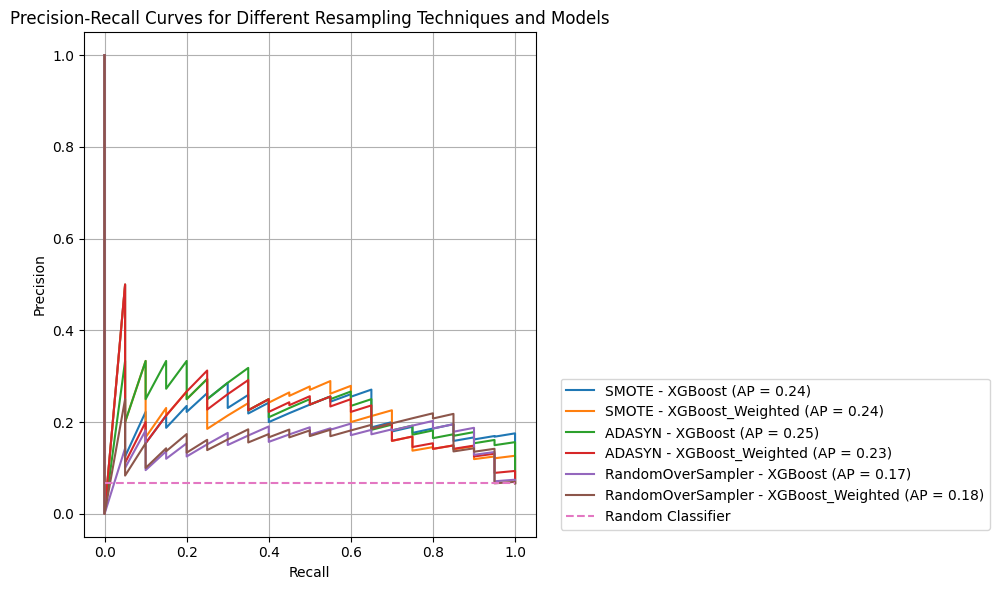


Top 10 Important Features:
         feature  importance
2          HbA1c    0.711821
9       Race_3.0    0.040383
10      Race_4.0    0.035921
5     Gender_1.0    0.031151
7       Race_1.0    0.028467
11      Race_5.0    0.028069
4   Diastolic_BP    0.027907
3    Systolic_BP    0.025826
1            BMI    0.025736
0            Age    0.024134


In [ ]:
#Handling Class Imbalance

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, cohen_kappa_score, f1_score, precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('modified_vitamin_d_dataset.csv')

# Redefine the target variable
data['Vitamin_D_Deficient'] = (data['Vitamin_D'] < 20).astype(int)

# Separate features and target
X = data.drop(['ID', 'Vitamin_D_Deficient', 'Vitamin_D'], axis=1)
y = data['Vitamin_D_Deficient']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, columns=['Gender', 'Race', 'Diabetes_Diagnosis'])

# Feature engineering (keeping it simple for this example)
X['HbA1c_Category'] = pd.cut(X['HbA1c'], bins=[0, 5.7, 6.4, 7, 8, np.inf], labels=['Normal', 'Prediabetes', 'Mild', 'Moderate', 'Severe'])
X = pd.get_dummies(X, columns=['HbA1c_Category'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define sampling techniques
sampling_techniques = {
    'SMOTE': SMOTE(sampling_strategy='auto', random_state=42),
    'ADASYN': ADASYN(sampling_strategy='auto', random_state=42),
    'RandomOverSampler': RandomOverSampler(sampling_strategy='auto', random_state=42)
}

# Define XGBoost models
xgb_models = {
    'XGBoost': XGBClassifier(random_state=42),
    'XGBoost_Weighted': XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]))
}

# Function to evaluate model
def evaluate_model(y_true, y_pred, y_pred_proba):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print(f"ROC AUC Score: {roc_auc_score(y_true, y_pred_proba):.4f}")
    print(f"Cohen's Kappa Score: {cohen_kappa_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")

# Evaluate different combinations
results = {}
for sampler_name, sampler in sampling_techniques.items():
    for model_name, model in xgb_models.items():
        print(f"\nEvaluating {sampler_name} with {model_name}")

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('sampler', sampler),
            ('classifier', model)
        ])

        # Fit the model
        pipeline.fit(X_train, y_train)

        # Make predictions
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

        # Evaluate the model
        evaluate_model(y_test, y_pred, y_pred_proba)

        # Store results
        results[(sampler_name, model_name)] = {
            'f1_score': f1_score(y_test, y_pred),
            'roc_auc_score': roc_auc_score(y_test, y_pred_proba),
            'cohen_kappa_score': cohen_kappa_score(y_test, y_pred),
            'y_pred_proba': y_pred_proba
        }

# Find the best model
best_model = max(results, key=lambda k: results[k]['f1_score'])
print(f"\nBest model: {best_model[0]} with {best_model[1]}")
print(f"F1 Score: {results[best_model]['f1_score']:.4f}")
print(f"ROC AUC Score: {results[best_model]['roc_auc_score']:.4f}")
print(f"Cohen's Kappa Score: {results[best_model]['cohen_kappa_score']:.4f}")

# Create precision-recall curves
plt.figure(figsize=(10, 6))

for (sampler_name, model_name), result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, result['y_pred_proba'])
    average_precision = average_precision_score(y_test, result['y_pred_proba'])

    plt.plot(recall, precision,
             label=f'{sampler_name} - {model_name} (AP = {average_precision:.2f})')

# Add a line for random classifier performance
random_performance = len(y_test[y_test == 1]) / len(y_test)
plt.plot([0, 1], [random_performance, random_performance],
         linestyle='--', label='Random Classifier')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Different Resampling Techniques and Models')
plt.legend(loc="lower left", bbox_to_anchor=(1.04, 0))
plt.grid(True)

# Adjust the plot to prevent clipping of labels
plt.tight_layout()

# Save the figure
plt.savefig('/content/drive/MyDrive/Shlok/Prepared_Datasets/results1/precision_recall_curves.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Retrain the best model
best_sampler = sampling_techniques[best_model[0]]
best_classifier = xgb_models[best_model[1]]
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sampler', best_sampler),
    ('classifier', best_classifier)
])
best_pipeline.fit(X_train, y_train)

# SHAP value analysis for the best model
explainer = shap.TreeExplainer(best_pipeline.named_steps['classifier'])
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Shlok/Prepared_Datasets/results1/shap_summary.png')
plt.close()

# Print feature importances
feature_importance = best_pipeline.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(10)
print("\nTop 10 Important Features:")
print(feature_importance_df)

In [ ]:
!pip install imblearn



> Add blockquote


#Ensemble Model

### 1. Data Preparation
- **Loading Data**: The dataset is loaded, and a binary target variable (`Vitamin_D_Deficient`) is created based on vitamin D levels.
- **Feature Selection**: Unnecessary columns are dropped, and categorical variables are converted into dummy variables.
- **Feature Engineering**: Additional features are created, including categories for HbA1c and interaction terms between HbA1c, BMI, and Age.

### 2. Data Splitting
- The dataset is split into training (80%) and testing (20%) sets using stratified sampling to maintain the distribution of the target variable.

### 3. Class Imbalance Handling
- **Sampling Techniques**: Two sampling methods are defined to address class imbalance:
  - SMOTE
  - SMOTETomek

### 4. Model Definition
- Three base models are defined for the ensemble:
  - XGBoost with class weights
  - Random Forest with balanced class weights
  - Logistic Regression with balanced class weights

### 5. Ensemble Model Creation
- A `VotingClassifier` is created to combine the predictions of the three base models using soft voting.

### 6. Model Evaluation Function
- A function (`evaluate_model`) is defined to print classification metrics, including the classification report, ROC AUC score, Cohen's Kappa score, and F1 score.

### 7. Threshold Optimization
- A function (`optimize_threshold`) calculates the optimal threshold for classification based on maximizing the F1 score.

### 8. Model Training and Evaluation
- The code iterates through each sampling technique, fitting the ensemble model using a pipeline that includes scaling, sampling, and classification.
- Predictions are made, the optimal threshold is determined, and the model is evaluated using the defined evaluation function. Results are stored for comparison.

### 9. Best Model Selection
- The best model is identified based on the highest F1 score, and its details are printed.

### 10. Retraining the Best Model
- The best model is retrained using the entire training dataset.

### 11. SHAP Analysis
- SHAP values are computed for the XGBoost model within the ensemble to analyze feature contributions, and a summary plot is saved.

### 12. Feature Importance
- The top 10 important features are extracted from the XGBoost model and printed.




In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, cohen_kappa_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
import shap
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('modified_vitamin_d_dataset.csv')

# Redefine the target variable
data['Vitamin_D_Deficient'] = (data['Vitamin_D'] < 20).astype(int)

# Separate features and target
X = data.drop(['ID', 'Vitamin_D_Deficient', 'Vitamin_D'], axis=1)
y = data['Vitamin_D_Deficient']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, columns=['Gender', 'Race', 'Diabetes_Diagnosis'])

# Feature engineering
X['HbA1c_Category'] = pd.cut(X['HbA1c'], bins=[0, 5.7, 6.4, 7, 8, np.inf], labels=['Normal', 'Prediabetes', 'Mild', 'Moderate', 'Severe'])
X = pd.get_dummies(X, columns=['HbA1c_Category'])

# Add more HbA1c-based features
X['HbA1c_squared'] = X['HbA1c'] ** 2
X['HbA1c_BMI'] = X['HbA1c'] * X['BMI']
X['HbA1c_Age'] = X['HbA1c'] * X['Age']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define sampling techniques
sampling_techniques = {
    'SMOTE': SMOTE(sampling_strategy='auto', random_state=42),
    'SMOTETomek': SMOTETomek(sampling_strategy='auto', random_state=42)
}

# Define base models for ensemble
xgb = XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]))
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
lr = LogisticRegression(random_state=42, class_weight='balanced')

# Create ensemble model
ensemble = VotingClassifier(
    estimators=[('xgb', xgb), ('rf', rf), ('lr', lr)],
    voting='soft'
)

# Function to evaluate model
def evaluate_model(y_true, y_pred, y_pred_proba):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print(f"ROC AUC Score: {roc_auc_score(y_true, y_pred_proba):.4f}")
    print(f"Cohen's Kappa Score: {cohen_kappa_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")

# Function for threshold optimization
def optimize_threshold(y_true, y_pred_proba):
    thresholds = np.arange(0, 1, 0.01)
    f1_scores = [f1_score(y_true, y_pred_proba > threshold) for threshold in thresholds]
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    return optimal_threshold

# Evaluate different combinations
results = {}
for sampler_name, sampler in sampling_techniques.items():
    print(f"\nEvaluating {sampler_name} with Ensemble")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('sampler', sampler),
        ('classifier', ensemble)
    ])

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Optimize threshold
    optimal_threshold = optimize_threshold(y_test, y_pred_proba)
    y_pred = (y_pred_proba > optimal_threshold).astype(int)

    print(f"Optimal threshold: {optimal_threshold:.2f}")

    # Evaluate the model
    evaluate_model(y_test, y_pred, y_pred_proba)

    # Store results
    results[sampler_name] = {
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc_score': roc_auc_score(y_test, y_pred_proba),
        'cohen_kappa_score': cohen_kappa_score(y_test, y_pred),
        'optimal_threshold': optimal_threshold
    }

# Find the best model
best_model = max(results, key=lambda k: results[k]['f1_score'])
print(f"\nBest model: {best_model}")
print(f"F1 Score: {results[best_model]['f1_score']:.4f}")
print(f"ROC AUC Score: {results[best_model]['roc_auc_score']:.4f}")
print(f"Cohen's Kappa Score: {results[best_model]['cohen_kappa_score']:.4f}")
print(f"Optimal Threshold: {results[best_model]['optimal_threshold']:.2f}")

# Retrain the best model
best_sampler = sampling_techniques[best_model]
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sampler', best_sampler),
    ('classifier', ensemble)
])
best_pipeline.fit(X_train, y_train)

# SHAP value analysis for the best model
# Note: SHAP doesn't directly support VotingClassifier, so we'll use XGBoost for SHAP analysis
xgb_model = best_pipeline.named_steps['classifier'].estimators_[0]
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig('shap_summary.png')
plt.close()

# Print feature importances (using XGBoost feature importances)
feature_importance = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(10)
print("\nTop 10 Important Features:")
print(feature_importance_df)


Evaluating SMOTE with Ensemble
Optimal threshold: 0.46
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       186
           1       0.27      0.69      0.39        13

    accuracy                           0.86       199
   macro avg       0.62      0.78      0.66       199
weighted avg       0.93      0.86      0.89       199

ROC AUC Score: 0.8726
Cohen's Kappa Score: 0.3284
F1 Score: 0.3913

Evaluating SMOTETomek with Ensemble
Optimal threshold: 0.71
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       186
           1       0.32      0.54      0.40        13

    accuracy                           0.89       199
   macro avg       0.64      0.73      0.67       199
weighted avg       0.92      0.89      0.91       199

ROC AUC Score: 0.8668
Cohen's Kappa Score: 0.3463
F1 Score: 0.4000

Best model: SMOTETomek
F1 Score: 0.4000
ROC AUC 

In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, brier_score_loss, roc_curve, auc, precision_recall_curve
from sklearn.calibration import calibration_curve

# Additional metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
brier_score = brier_score_loss(y_test, y_pred_proba)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Brier Score: {brier_score:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.savefig('confusion_matrix.png')
plt.close()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.close()

# Precision-recall curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall_curve, precision_curve)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.savefig('precision_recall_curve.png')
plt.close()

# Calibration plot
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', linewidth=1)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.savefig('calibration_plot.png')
plt.close()

# Feature importance plot
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.savefig('feature_importance_plot.png')
plt.close()

# SHAP dependence plots
for feature in feature_importance_df['feature'][:5]:  # Plot for top 5 features
    shap.dependence_plot(feature, shap_values, X_test, show=False)
    plt.tight_layout()
    plt.savefig(f'shap_dependence_{feature}.png')
    plt.close()

Precision: 0.3182
Recall: 0.5385
Brier Score: 0.1063


### Final code with all plots and metrics - Ensemble Model - SMOTE and SMOTETOMEK 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, cohen_kappa_score, f1_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv('modified_vitamin_d_dataset.csv')

# Redefine the target variable
data['Vitamin_D_Deficient'] = (data['Vitamin_D'] < 20).astype(int)

# Separate features and target
X = data.drop(['ID', 'Vitamin_D_Deficient', 'Vitamin_D'], axis=1)
y = data['Vitamin_D_Deficient']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, columns=['Gender', 'Race', 'Diabetes_Diagnosis'])

# Feature engineering
X['HbA1c_Category'] = pd.cut(X['HbA1c'], bins=[0, 5.7, 6.4, 7, 8, np.inf], labels=['Normal', 'Prediabetes', 'Mild', 'Moderate', 'Severe'])
X = pd.get_dummies(X, columns=['HbA1c_Category'])

# Add more HbA1c-based features
X['HbA1c_squared'] = X['HbA1c'] ** 2
X['HbA1c_BMI'] = X['HbA1c'] * X['BMI']
X['HbA1c_Age'] = X['HbA1c'] * X['Age']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define sampling techniques
sampling_techniques = {
    'SMOTE': SMOTE(sampling_strategy='auto', random_state=42),
    'SMOTETomek': SMOTETomek(sampling_strategy='auto', random_state=42)
}

# Define base models for ensemble
xgb = XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]))
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
lr = LogisticRegression(random_state=42, class_weight='balanced')

# Create ensemble model
ensemble = VotingClassifier(
    estimators=[('xgb', xgb), ('rf', rf), ('lr', lr)],
    voting='soft'
)

# Function to evaluate model
def evaluate_model(y_true, y_pred, y_pred_proba):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print(f"ROC AUC Score: {roc_auc_score(y_true, y_pred_proba):.4f}")
    print(f"Cohen's Kappa Score: {cohen_kappa_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")

# Function for threshold optimization
def optimize_threshold(y_true, y_pred_proba):
    thresholds = np.arange(0, 1, 0.01)
    f1_scores = [f1_score(y_true, y_pred_proba > threshold) for threshold in thresholds]
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    return optimal_threshold

# Function to calculate Cohen's Kappa
def calculate_cohen_kappa(estimator, X, y):
    y_pred = estimator.predict(X)
    return cohen_kappa_score(y, y_pred)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, cohen_kappa_score, f1_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv('modified_vitamin_d_dataset.csv')

# Redefine the target variable
data['Vitamin_D_Deficient'] = (data['Vitamin_D'] < 20).astype(int)

# Separate features and target
X = data.drop(['ID', 'Vitamin_D_Deficient', 'Vitamin_D'], axis=1)
y = data['Vitamin_D_Deficient']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, columns=['Gender', 'Race', 'Diabetes_Diagnosis'])

# Feature engineering
X['HbA1c_Category'] = pd.cut(X['HbA1c'], bins=[0, 5.7, 6.4, 7, 8, np.inf], labels=['Normal', 'Prediabetes', 'Mild', 'Moderate', 'Severe'])
X = pd.get_dummies(X, columns=['HbA1c_Category'])

# Add more HbA1c-based features
X['HbA1c_squared'] = X['HbA1c'] ** 2
X['HbA1c_BMI'] = X['HbA1c'] * X['BMI']
X['HbA1c_Age'] = X['HbA1c'] * X['Age']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define sampling techniques
sampling_techniques = {
    'SMOTE': SMOTE(sampling_strategy='auto', random_state=42),
    'SMOTETomek': SMOTETomek(sampling_strategy='auto', random_state=42)
}

# Define base models for ensemble
xgb = XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]))
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
lr = LogisticRegression(random_state=42, class_weight='balanced')

# Create ensemble model
ensemble = VotingClassifier(
    estimators=[('xgb', xgb), ('rf', rf), ('lr', lr)],
    voting='soft'
)

# Function to evaluate model
def evaluate_model(y_true, y_pred, y_pred_proba):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print(f"ROC AUC Score: {roc_auc_score(y_true, y_pred_proba):.4f}")
    print(f"Cohen's Kappa Score: {cohen_kappa_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")

# Function for threshold optimization
def optimize_threshold(y_true, y_pred_proba):
    thresholds = np.arange(0, 1, 0.01)
    f1_scores = [f1_score(y_true, y_pred_proba > threshold) for threshold in thresholds]
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    return optimal_threshold

# Function to calculate Cohen's Kappa
def calculate_cohen_kappa(estimator, X, y):
    y_pred = estimator.predict(X)
    return cohen_kappa_score(y, y_pred)

# Initialize dictionaries
results = {}
cv_results = {}
model_predictions = {}  # Initialize model_predictions dictionary
f1_scores, roc_auc_scores, kappa_scores = [], [], []

for sampler_name, sampler in sampling_techniques.items():
    print(f"\nEvaluating {sampler_name} with Ensemble")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('sampler', sampler),
        ('classifier', ensemble)
    ])

    # Perform cross-validation
    cv_f1_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
    cv_roc_auc_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')

    # For Cohen's Kappa, we need to use cross_val_predict and calculate the score manually
    y_pred = cross_val_predict(pipeline, X_train, y_train, cv=5)
    cv_kappa_score = cohen_kappa_score(y_train, y_pred)

    f1_scores.extend(cv_f1_scores)
    roc_auc_scores.extend(cv_roc_auc_scores)
    kappa_scores.append(cv_kappa_score)  # Note: This will be a single score for all folds

    cv_results[sampler_name] = cv_f1_scores

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    model_predictions[sampler_name] = y_pred_proba  # Store predictions for ROC curve

    # Optimize threshold
    optimal_threshold = optimize_threshold(y_test, y_pred_proba)
    y_pred = (y_pred_proba > optimal_threshold).astype(int)

    print(f"Optimal threshold: {optimal_threshold:.2f}")

    # Evaluate the model
    evaluate_model(y_test, y_pred, y_pred_proba)

    # Store results
    results[sampler_name] = {
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc_score': roc_auc_score(y_test, y_pred_proba),
        'cohen_kappa_score': cohen_kappa_score(y_test, y_pred),
        'optimal_threshold': optimal_threshold
    }

# Plot ROC curves
plt.figure(figsize=(10, 8))
for model_name, y_pred_proba in model_predictions.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/Shlok/Prepared_Datasets/results3/roc_curve_comparison.png')
plt.close()

# Find the best model
best_model = max(results, key=lambda k: results[k]['f1_score'])
print(f"\nBest model: {best_model}")
print(f"F1 Score: {results[best_model]['f1_score']:.4f}")
print(f"ROC AUC Score: {results[best_model]['roc_auc_score']:.4f}")
print(f"Cohen's Kappa Score: {results[best_model]['cohen_kappa_score']:.4f}")
print(f"Optimal Threshold: {results[best_model]['optimal_threshold']:.2f}")

# Retrain the best model
best_sampler = sampling_techniques[best_model]
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sampler', best_sampler),
    ('classifier', ensemble)
])
best_pipeline.fit(X_train, y_train)

# SHAP value analysis for the best model
# Note: SHAP doesn't directly support VotingClassifier, so we'll use XGBoost for SHAP analysis
xgb_model = best_pipeline.named_steps['classifier'].estimators_[0]
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Shlok/Prepared_Datasets/results3/shap_summary.png')
plt.close()

# Print feature importances (using XGBoost feature importances)
feature_importance = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(10)
print("\nTop 10 Important Features:")
print(feature_importance_df)

# Visualize cross-validation results
plt.figure(figsize=(12, 6))
sns.boxplot(data=list(cv_results.values()))
plt.xticks(range(len(cv_results)), list(cv_results.keys()))
plt.xlabel('Sampling Technique')
plt.ylabel('F1 Score')
plt.title('Distribution of F1 Scores Across Folds for Different Sampling Techniques')
plt.savefig('/content/drive/MyDrive/Shlok/Prepared_Datasets/results3/cv_results_boxplot.png')
plt.close()

# New visualization: Violin plot of performance metrics
metrics = ['F1 Score', 'ROC AUC', 'Cohen\'s Kappa']
values = [f1_scores, roc_auc_scores, kappa_scores]
plt.figure(figsize=(10, 6))
sns.violinplot(data=values)
plt.xticks(range(len(metrics)), metrics)
plt.ylabel('Score')
plt.title('Distribution of Performance Metrics Across Cross-Validation Folds')
plt.savefig('/content/drive/MyDrive/Shlok/Prepared_Datasets/results3/performance_metrics_violin.png')
plt.close()
# Find the best model
best_model = max(results, key=lambda k: results[k]['f1_score'])
print(f"\nBest model: {best_model}")
print(f"F1 Score: {results[best_model]['f1_score']:.4f}")
print(f"ROC AUC Score: {results[best_model]['roc_auc_score']:.4f}")
print(f"Cohen's Kappa Score: {results[best_model]['cohen_kappa_score']:.4f}")
print(f"Optimal Threshold: {results[best_model]['optimal_threshold']:.2f}")

# Retrain the best model
best_sampler = sampling_techniques[best_model]
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sampler', best_sampler),
    ('classifier', ensemble)
])
best_pipeline.fit(X_train, y_train)

# SHAP value analysis for the best model
# Note: SHAP doesn't directly support VotingClassifier, so we'll use XGBoost for SHAP analysis
xgb_model = best_pipeline.named_steps['classifier'].estimators_[0]
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Shlok/Prepared_Datasets/results3/shap_summary.png')
plt.close()

# Print feature importances (using XGBoost feature importances)
feature_importance = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(10)
print("\nTop 10 Important Features:")
print(feature_importance_df)

# Visualize cross-validation results
plt.figure(figsize=(12, 6))
sns.boxplot(data=list(cv_results.values()))
plt.xticks(range(len(cv_results)), list(cv_results.keys()))
plt.xlabel('Sampling Technique')
plt.ylabel('F1 Score')
plt.title('Distribution of F1 Scores Across Folds for Different Sampling Techniques')
plt.savefig('/content/drive/MyDrive/Shlok/Prepared_Datasets/results3/cv_results_boxplot.png')
plt.close()

# New visualization: Violin plot of performance metrics
metrics = ['F1 Score', 'ROC AUC', 'Cohen\'s Kappa']
values = [f1_scores, roc_auc_scores, kappa_scores]
plt.figure(figsize=(10, 6))
sns.violinplot(data=values)
plt.xticks(range(len(metrics)), metrics)
plt.ylabel('Score')
plt.title('Distribution of Performance Metrics Across Cross-Validation Folds')
plt.savefig('/content/drive/MyDrive/Shlok/Prepared_Datasets/results3/performance_metrics_violin.png')
plt.close()


Evaluating SMOTE with Ensemble
Optimal threshold: 0.46
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       186
           1       0.27      0.69      0.39        13

    accuracy                           0.86       199
   macro avg       0.62      0.78      0.66       199
weighted avg       0.93      0.86      0.89       199

ROC AUC Score: 0.8726
Cohen's Kappa Score: 0.3284
F1 Score: 0.3913

Evaluating SMOTETomek with Ensemble
Optimal threshold: 0.71
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       186
           1       0.32      0.54      0.40        13

    accuracy                           0.89       199
   macro avg       0.64      0.73      0.67       199
weighted avg       0.92      0.89      0.91       199

ROC AUC Score: 0.8668
Cohen's Kappa Score: 0.3463
F1 Score: 0.4000

Best model: SMOTETomek
F1 Score: 0.4000
ROC AUC 